In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Constants for the problem
sequence_length = 128  # s
model_dimension = 512  # d
feedforward_dimension = 2048  # ff
num_heads = 8  # h

# Step 1: Calculate FLOPs

# Calculating FLOPs for MHSA blocks
#num of mhsa = 2
# MHSA FLOPs = num_of_mhsa * (2*s * d^2 + 4s^2s * d)
mhsa_flops =  2 * ((2 * sequence_length * pow(model_dimension,2))+
                  (4*pow(sequence_length,2) * model_dimension))

# Calculating FLOPs for Feedforward Networks
#total Feedforward networks = 2
# Feedforward FLOPs = total_ffns * 2  (s * d * ff )
feedforward_flops = 2 * 2 * (sequence_length *model_dimension*feedforward_dimension)

# Total FLOPs (MHSA + Feedforward)
total_flops = (mhsa_flops + feedforward_flops)

In [3]:

# Step 2: Memory footprint

# Estimating memory access (Bytes) for 32-bit precision (4 bytes per element)
# Memory access includes input/output tensors and weights
#MEM_QKV = 3*d^2
#MEM_out= d^2
#double since there is two networks
#parameters
mhsa_parameter_footprint = 2 *(3*pow(model_dimension,2)+ pow(model_dimension,2))

mhsa_activation_footprint =2* (sequence_length*model_dimension+ pow(sequence_length,2)*model_dimension)

#activations
feedforward_parameter_footprint = 2*2*(model_dimension*feedforward_dimension)

feedforward_activation_footprint = 2* (sequence_length*model_dimension+sequence_length*feedforward_dimension)

# Total Memory Footprint
total_memory_access = (mhsa_parameter_footprint + feedforward_parameter_footprint + feedforward_activation_footprint + mhsa_activation_footprint) * 4

In [4]:

# Step 3: Calculate Operational Intensity
operational_intensity = total_flops / total_memory_access

# Print out the results
print(f"Total FLOPs: {total_flops:.2e} FLOPs")
print(f"Total Memory Access: {total_memory_access:.2e} Bytes")
print(f"Operational Intensity: {operational_intensity:.3f} FLOPs/Byte")

Total FLOPs: 7.38e+08 FLOPs
Total Memory Access: 9.54e+07 Bytes
Operational Intensity: 7.736 FLOPs/Byte


Peak Flops: 7.177 TFLOPs


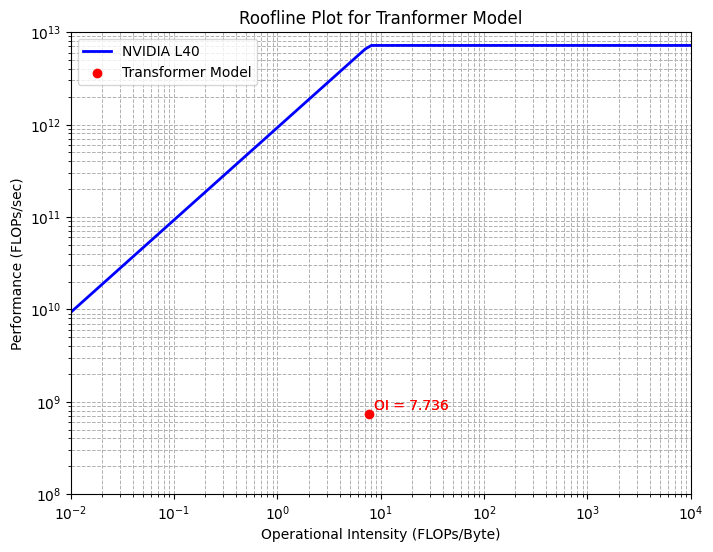

In [5]:

# Step 4: Roofline Plot

# memory bandwidth from https://images.nvidia.com/content/Solutions/data-center/vgpu-L40-datasheet.pdf
memory_bandwidth = 864 *pow(2,30) # gigabyte conversion 2^30, Bytes/sec
peak_flops = memory_bandwidth *  operational_intensity
print(f"Peak Flops: {peak_flops*pow(10,-12):.3f} TFLOPs")


# Define operational intensity range for plotting
oi_range = np.logspace(-2, 4, 100)

# Roofline curve
performance_roofline = np.minimum(peak_flops, memory_bandwidth * oi_range)

# Plotting the roofline
plt.figure(figsize=(8, 6))
plt.loglog(oi_range, performance_roofline, label="NVIDIA L40", color="blue", linewidth=2)

# Plot the operational intensity of the model
plt.scatter(operational_intensity, total_flops, color="red", label="Transformer Model", zorder=5)

# Annotating the point
plt.text(operational_intensity * 1.1, total_flops * 1.1, 'OI = {:.3f}'.format(operational_intensity), color='red')
plt.text(operational_intensity * 1.1, total_flops * 1.1, 'OI = {:.3f}'.format(operational_intensity), color='red')

# Adding labels and title
plt.title("Roofline Plot for Tranformer Model")
plt.xlabel("Operational Intensity (FLOPs/Byte)")
plt.ylabel("Performance (FLOPs/sec)")
plt.grid(True, which="both", linestyle='--', linewidth=0.7)

# Setting limits for better visualization
plt.xlim([1e-2, 1e4])
plt.ylim([1e8, 1e13])  # From 100 MFLOP/s to 10 TFLOPs

# Show plot
plt.legend()
plt.show()
